# Z calibration dev

Here we'll develop the z calibration routines

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.external.tifffile as tif
%load_ext autoreload
%autoreload 2
from peaks.stackanalysis import PSFStackAnalyzer

In [2]:
data = tif.imread("Z Calibration/Cell5_532nm_Calib.tif")

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [3]:
bg = tif.imread("Camera Calibration/dark_wo_1st_512x512_mean.tif")

In [4]:
psf = PSFStackAnalyzer(data, 1.5)
psf_nb = PSFStackAnalyzer(data - bg, 1.5)
psfs = dict(psf=psf, psf_nb=psf_nb)

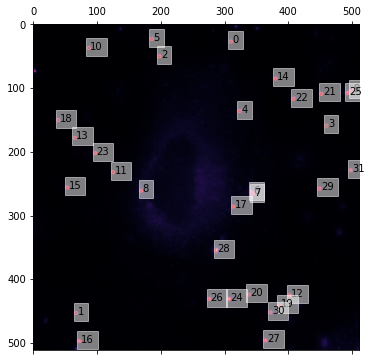

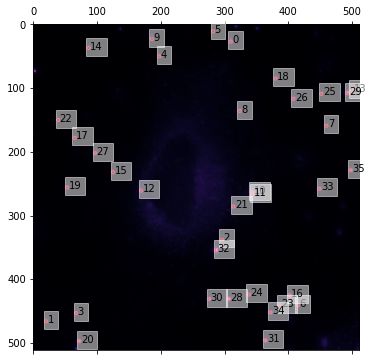

In [5]:
for k, p in psfs.items():
    p.peakfinder.find_blobs()
    p.peakfinder.remove_edge_blobs(10)
    p.peakfinder.plot_blobs(cmap="inferno")

In [6]:
%time f = p.fitPeaks(7, 12)

Wall time: 24.6 s


In [7]:
p_wO = p.calc_psf_params(trim=1)
p_woO = p.calc_psf_params(trim=1, withoffset=False)

In [8]:
(p_wO - p_woO).dropna().z0 * 20

peak_num
1      243.009688
2     1194.136700
3        0.424150
4        0.846738
5        3.097351
6     1632.424368
8       -0.631930
9     1134.187308
10    1104.655432
11       6.780177
13       3.415556
14      -0.363019
15      54.491842
16      60.786575
17       1.315125
18      -0.474103
19      -2.116568
20       2.656283
22       1.226973
23       1.333385
24      -0.522869
25      -0.466601
26      -0.609382
27      -0.319504
28       0.121608
29       2.919701
30       0.132731
31       0.929958
32      -1.159647
33       0.951135
34       0.265832
35      42.996908
Name: z0, dtype: float64

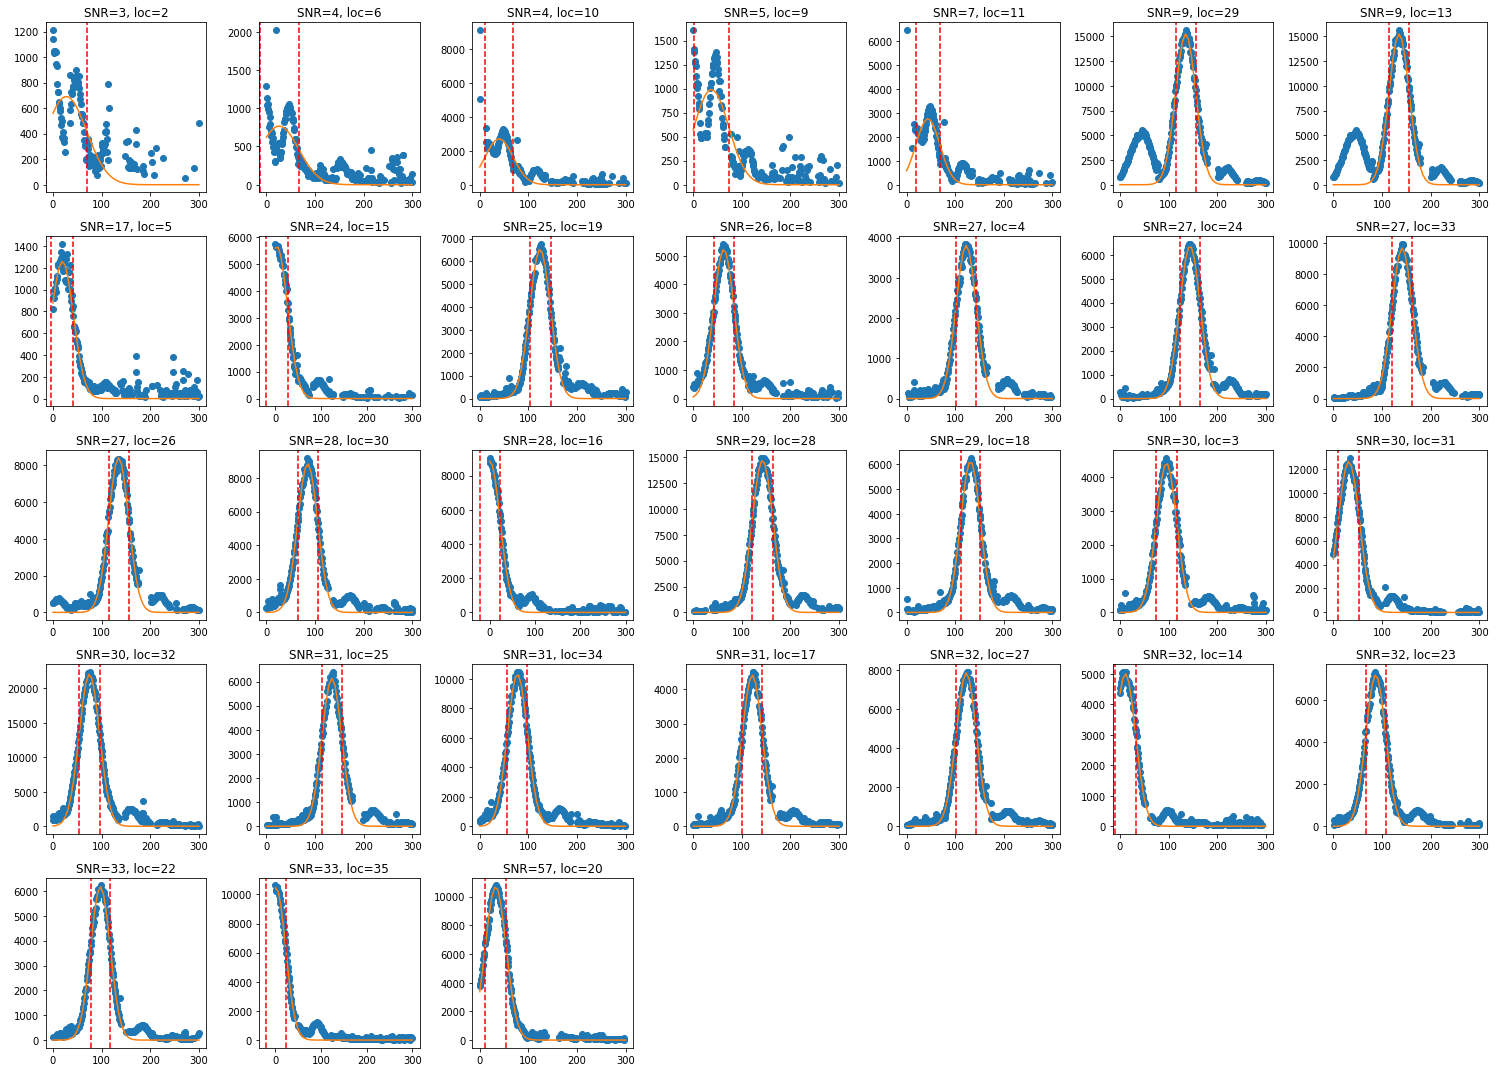

In [9]:
p.diagnostic_fits(-1, 1);

In [10]:
import tqdm

In [109]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    p.fits_dict = {}
    for method in tqdm.tqdm_notebook(("ls", "mle")):
        p.fits_dict[method] = {}
        for fitwin in tqdm.tqdm_notebook((9, 11, 13, 15, 17, 19)):
            fits = p.fitPeaks(fitwin, 12, fittype=method)
            psf_params = p.calc_psf_params(trim=1, withoffset=False)
            p.fits_dict[method][fitwin] = dict(psf_params=psf_params, fits=fits)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


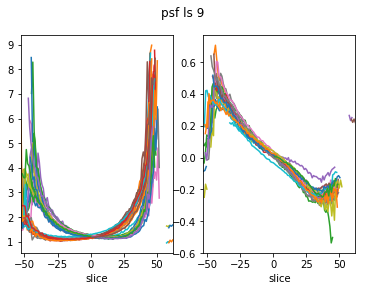

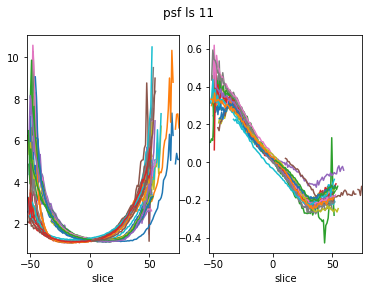

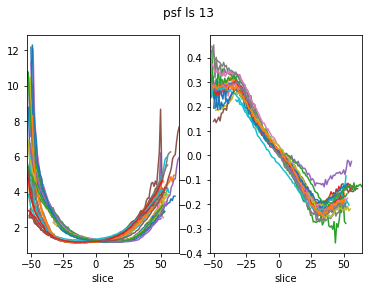

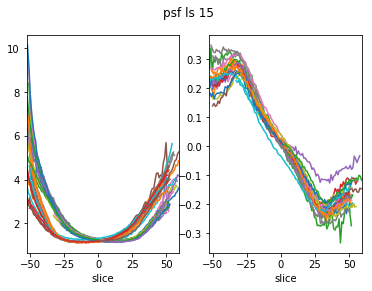

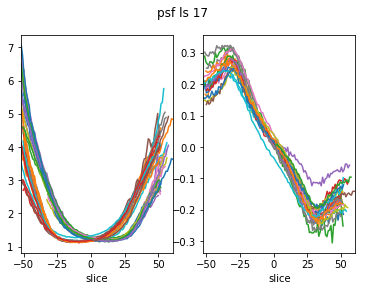

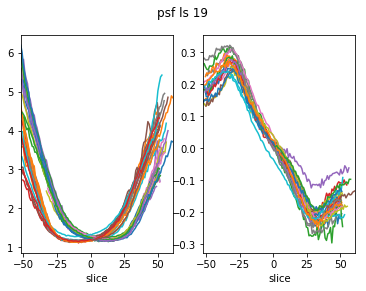

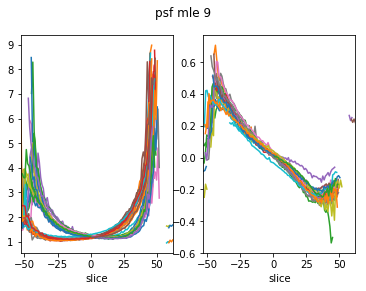

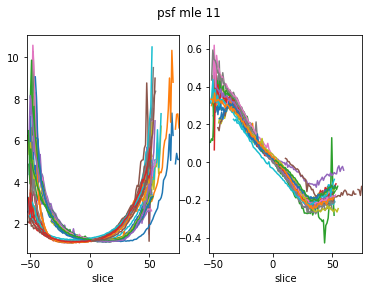

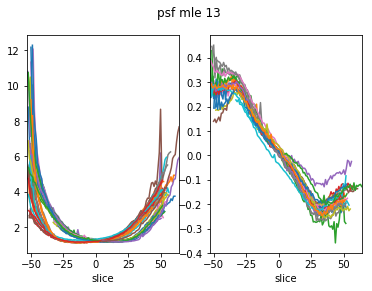

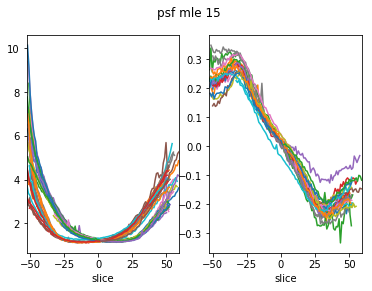

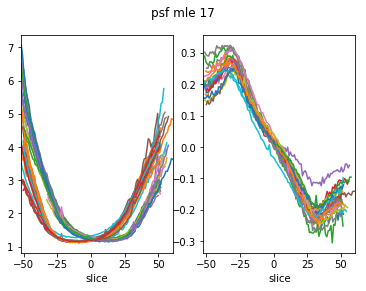

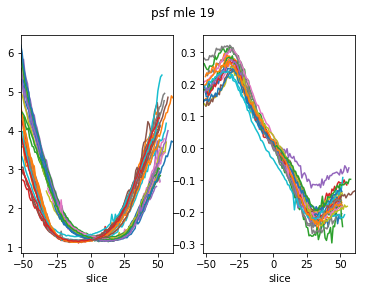

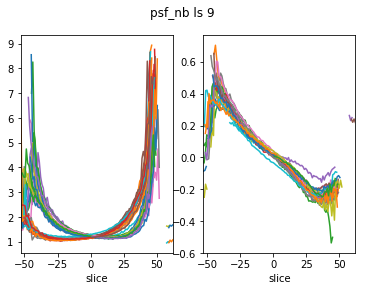

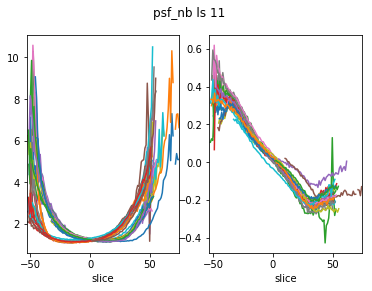

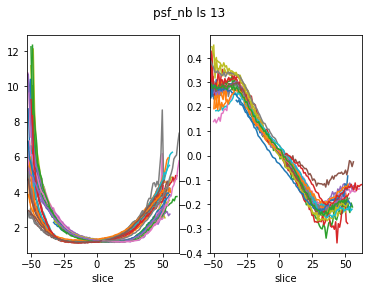

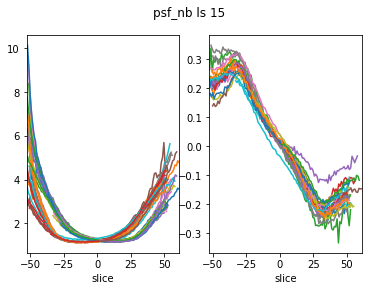

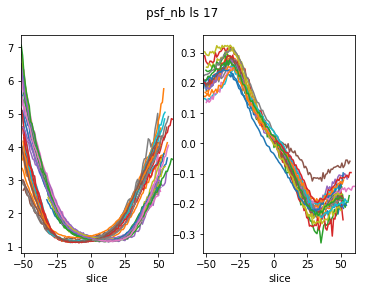

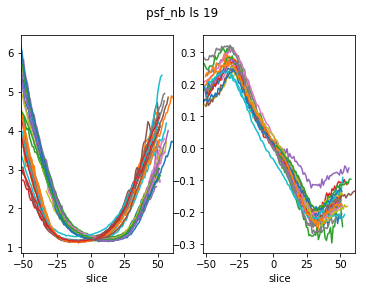

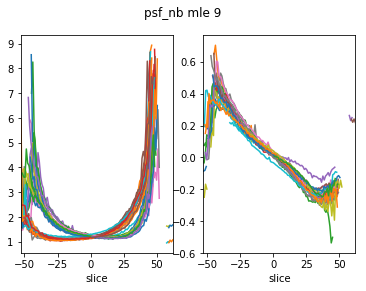

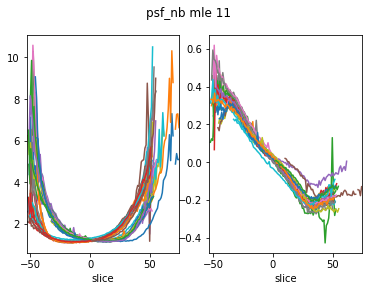

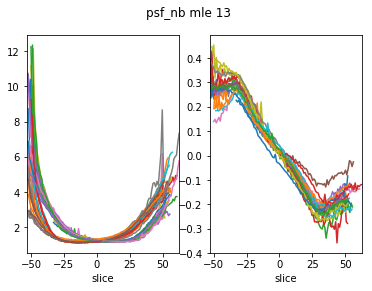

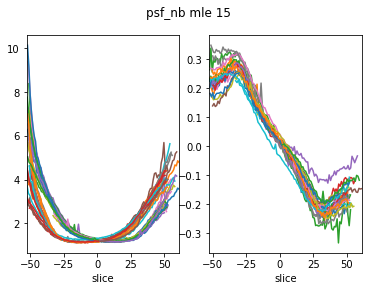

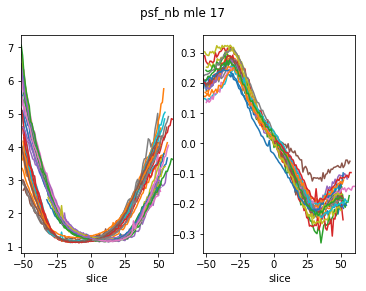

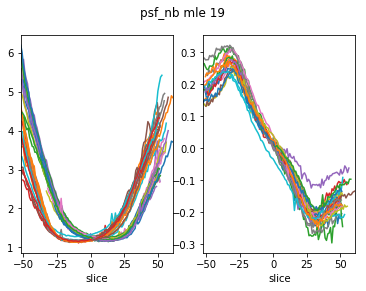

In [110]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            fits = fit_dict["fits"]
            psf_params = fit_dict["psf_params"]
            fig, (ax0, ax1) = plt.subplots(1, 2)
            fig.suptitle("{} {} {}".format(k, method, fitwin))
            new_fits = []
            for i, param in psf_params.iterrows():
                if param.SNR > 20:
                    fit = fits[i].copy()
                    fit.index -= param.z0
                    num_frames = 2.5 * np.abs(param.sigma_z)
                    fit = fit[np.abs(fit.index) < num_frames]
                    if len(fit) > 0.8 * num_frames:
                        fit[["sigma_x", "sigma_y"]].plot(ax=ax0, legend=False)
                        fit["ellip"] = ((fit.sigma_x - fit.sigma_y)/(fit.sigma_x + fit.sigma_y))
                        fit.ellip.plot(ax=ax1, label=i)
                        new_fits.append(fit)
#                 break
#             break
            new_fits = pd.concat(new_fits)
#         break
#     break

In [111]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            fits = fit_dict["fits"]
            psf_params = fit_dict["psf_params"]
            new_fits = []
            for i, param in psf_params.iterrows():
                if param.SNR > 20:
                    num_frames = 2 * np.abs(param.sigma_z)
                    fit = fits[i].copy()
                    # shift index
                    fit.index -= param.z0
#                     fit = fit[np.abs(fit.index) < num_frames]
                    fit[["x0", "y0"]] -= fit[["x0", "y0"]][np.abs(fit.index) < num_frames].mean()
                    fit["ellip"] = ((fit.sigma_x - fit.sigma_y)/(fit.sigma_x + fit.sigma_y))
                    new_fits.append(fit)
            # put corrected fits into dict
            fit_dict["corrected_fits"] = pd.concat(new_fits).sort_index()

A Jupyter Widget

A Jupyter Widget

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


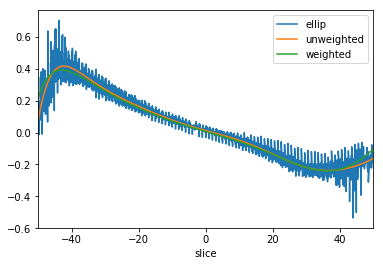

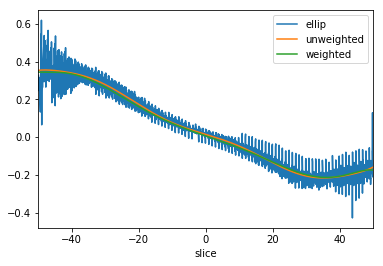

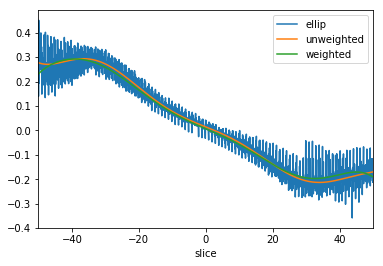

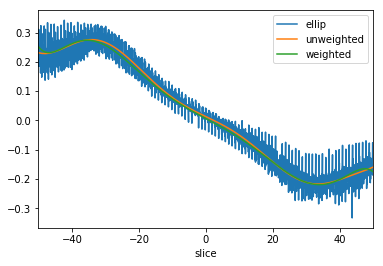

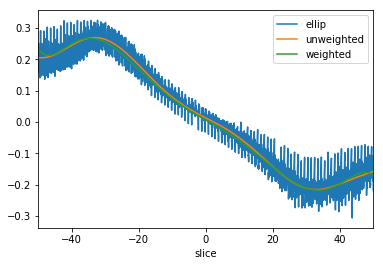

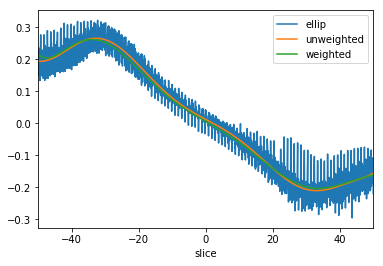

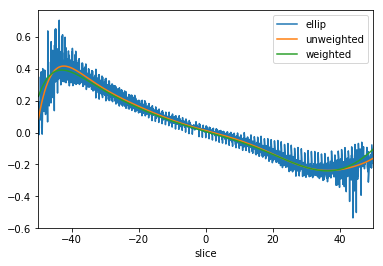

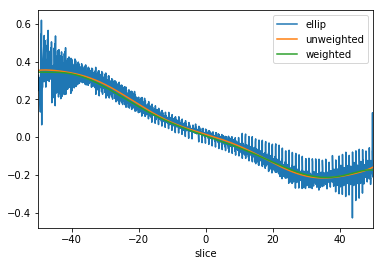

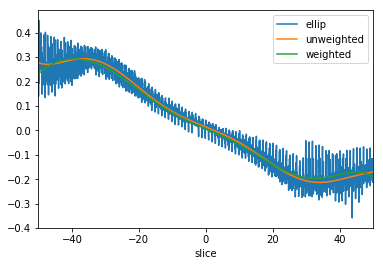

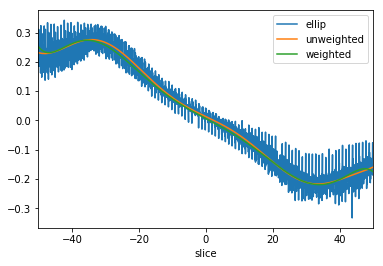

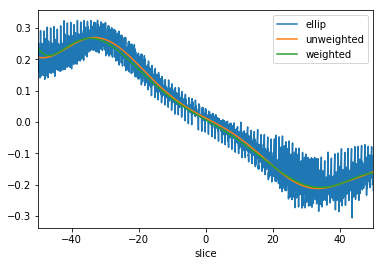

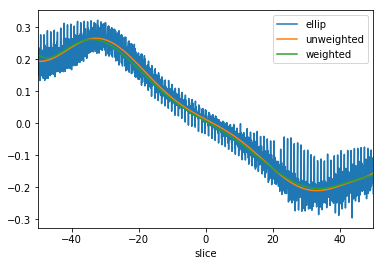

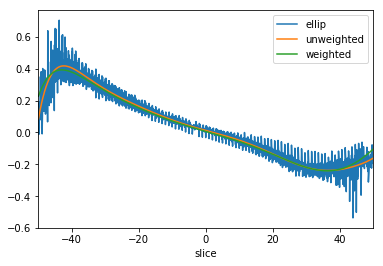

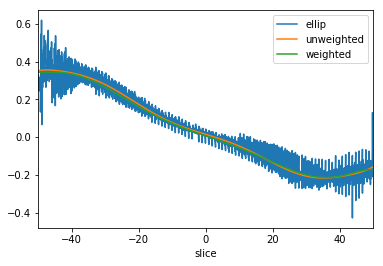

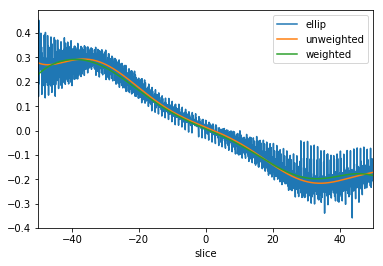

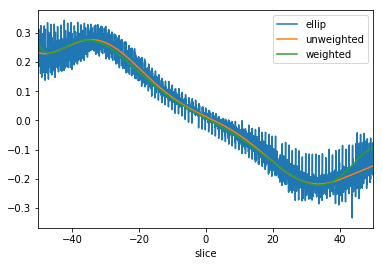

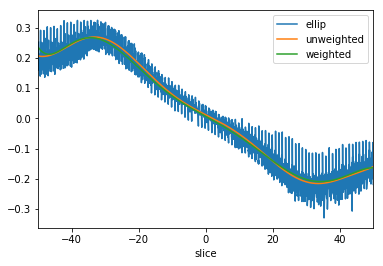

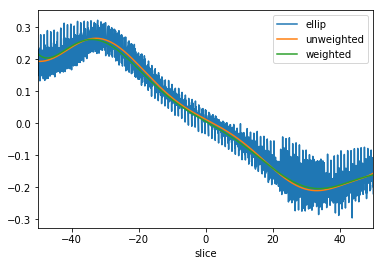

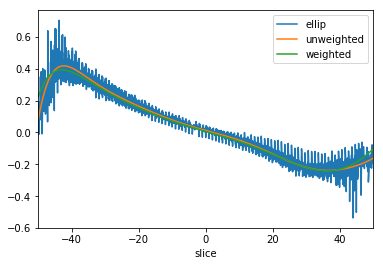

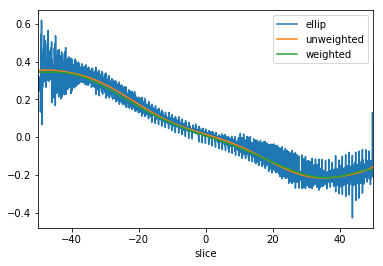

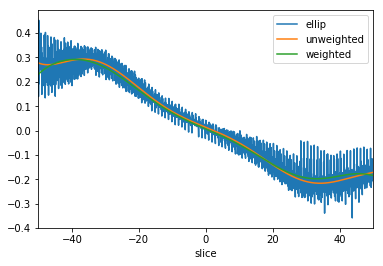

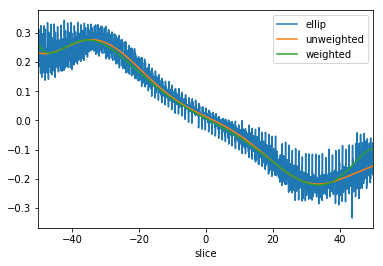

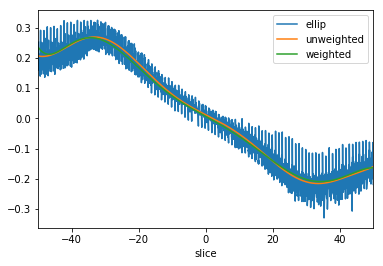

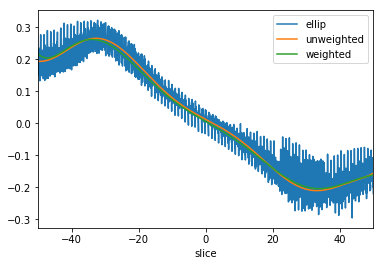

In [112]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            for kk in ("ellip", ):
                v = fit_dict["corrected_fits"]
                v = v[np.abs(v.index) < 50]
                v = v.dropna()
                polys = [np.poly1d(np.polyfit(v.index, v[kk], 9, w=w)) for w in [None, v.amp]]
                fig, ax = plt.subplots()
                v[kk].plot(ax=ax)
                for poly, l in zip(polys, ("unweighted", "weighted")):
                    ax.plot(v.index, poly(v.index), label=l)
            #         ax.axvline(xmin, c="r")
            #         ax.axvline(xmax, c="r")
                ax.legend()
#                 raise StopIteration

In [113]:
def find_real_roots_near_zero(poly):
    # convert array-like to poly
    poly = np.poly1d(poly)
    r = poly.roots
    r = r[~np.iscomplex(r)].real
    r.sort()
    i = np.abs(r).argmin()
    r1 = r[i]
    if r1 < 0:
        return r[i:i + 2]
    else:
        return r[i - 1:i + 1]

In [114]:
polyd = poly.deriv()
%timeit find_real_roots_near_zero(polyd)

109 µs ± 676 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


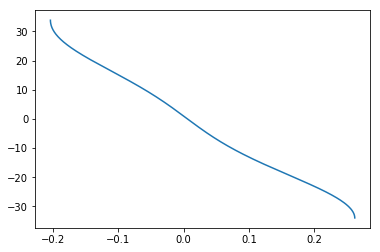

In [115]:
xmin, xmax = find_real_roots_near_zero(polyd)
x = v.index[(v.index < xmax) & (v.index > xmin)]
y = poly(x)
plt.plot(y, x)

In [116]:
s = y.argsort()
%timeit np.interp(0.1, y[s], x[s])

22.6 µs ± 651 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [117]:
from scipy.interpolate import interp1d

In [118]:
f = interp1d(y, x)
%timeit f(0.1)

20.6 µs ± 498 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


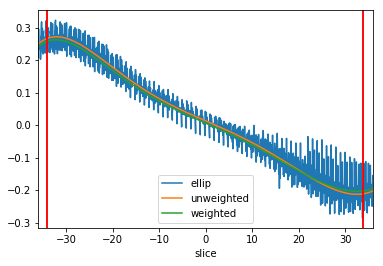

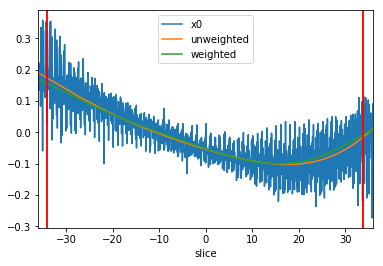

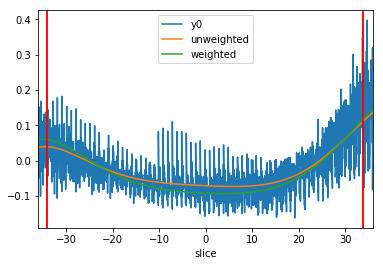

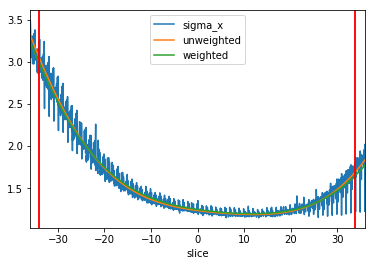

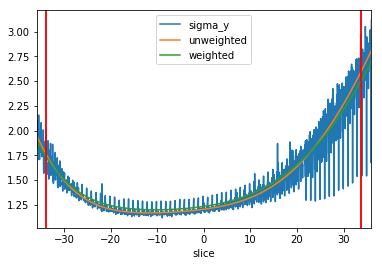

In [120]:
for k in ("ellip", "x0", "y0", "sigma_x", "sigma_y"):
    v = fit_dict["corrected_fits"]
    v = v[np.abs(v.index) < 36]
    polys = [np.poly1d(np.polyfit(v.index, v[k], 6, w=w)) for w in [None, v.amp]]
    fig, ax = plt.subplots()
    v[k].plot(ax=ax)
    for poly, l in zip(polys, ("unweighted", "weighted")):
        ax.plot(v.index, poly(v.index), label=l)
        if k == "ellip":
            xmin, xmax = find_real_roots_near_zero(polyd)
        ax.axvline(xmin, c="r")
        ax.axvline(xmax, c="r")
    ax.legend()

In [125]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            v = fit_dict["corrected_fits"]
            d = {}
            for k in ("ellip", "x0", "y0", "sigma_x", "sigma_y"):
                if k == "ellip":
                    r = 50
                    deg = 11
                else:
                    r = 36
                    deg = 6
                v = v[np.abs(v.index) < r].dropna()
                d[k] = np.polyfit(v.index, v[k], deg)
            df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in d.items()]))
            df.index.name = "coefs"
            fit_dict["poly_df"] = df 

A Jupyter Widget

In [126]:
from dphplotting import make_grid

A Jupyter Widget

              ellip       sigma_x       sigma_y            x0            y0
coefs                                                                      
0      2.798839e-19  1.777943e-10  7.684061e-12  3.494476e-11 -4.728736e-11
1     -3.017467e-18  8.865408e-10  2.590078e-09 -9.616455e-10  1.135016e-09
2     -8.602341e-16  9.691873e-08  2.806582e-07  4.974473e-08  1.630153e-07
3     -2.812525e-14 -5.385090e-06  7.211371e-06  1.149060e-06  5.122350e-07
4      2.450248e-13  2.861655e-04  2.403255e-04  5.262627e-05  3.463078e-05
5      1.172441e-10 -6.781698e-03  7.719469e-03 -4.334933e-03 -6.514436e-04
6      2.974867e-09  1.206808e+00  1.175593e+00 -7.747841e-02 -8.551769e-02
7     -8.882486e-08           NaN           NaN           NaN           NaN
8     -4.946100e-06           NaN           NaN           NaN           NaN
9      2.257218e-05           NaN           NaN           NaN           NaN
10    -5.942313e-03           NaN           NaN           NaN           NaN
11     1.295

11     1.426968e-02           NaN           NaN           NaN           NaN
              ellip       sigma_x       sigma_y            x0            y0
coefs                                                                      
0      6.183101e-19 -3.581882e-11 -7.880067e-11 -2.730768e-12 -7.474914e-11
1      2.621141e-18  5.421226e-10 -7.274638e-09  3.428907e-10  6.594961e-10
2     -3.621798e-15  5.099035e-07  4.506475e-07  6.802173e-08  1.778631e-07
3     -6.131077e-15 -9.972150e-06  1.502777e-05  6.792871e-07  8.450573e-07
4      5.907774e-12  3.129128e-04  2.896203e-04  5.062193e-05  3.619326e-05
5     -1.484238e-11 -7.605944e-03  5.796655e-03 -4.409622e-03 -6.226046e-04
6      6.392515e-10  1.223655e+00  1.191217e+00 -5.987277e-02 -7.811420e-02
7      4.214141e-08           NaN           NaN           NaN           NaN
8     -5.399405e-06           NaN           NaN           NaN           NaN
9     -2.641399e-06           NaN           NaN           NaN           NaN
10    -6.002

11     1.363351e-02           NaN           NaN           NaN           NaN
              ellip       sigma_x       sigma_y            x0            y0
coefs                                                                      
0      6.864314e-19 -8.245695e-11 -2.675867e-11 -2.588495e-11 -9.501107e-11
1     -7.391486e-18  2.857281e-09 -7.907535e-09  7.522020e-10  2.849625e-10
2     -3.899140e-15  6.124319e-07  4.595971e-07  8.679431e-08  1.984781e-07
3      5.057608e-14 -1.385978e-05  1.489407e-05  2.937283e-07  1.301678e-06
4      5.932894e-12  3.572783e-04  3.313795e-04  5.504908e-05  2.552613e-05
5     -1.166965e-10 -7.669956e-03  5.937020e-03 -4.073761e-03 -8.021413e-04
6      1.574483e-09  1.233898e+00  1.203853e+00 -5.700646e-02 -7.108796e-02
7      9.490843e-08           NaN           NaN           NaN           NaN
8     -5.825393e-06           NaN           NaN           NaN           NaN
9     -6.941067e-06           NaN           NaN           NaN           NaN
10    -6.159

11     1.328355e-02           NaN           NaN           NaN           NaN



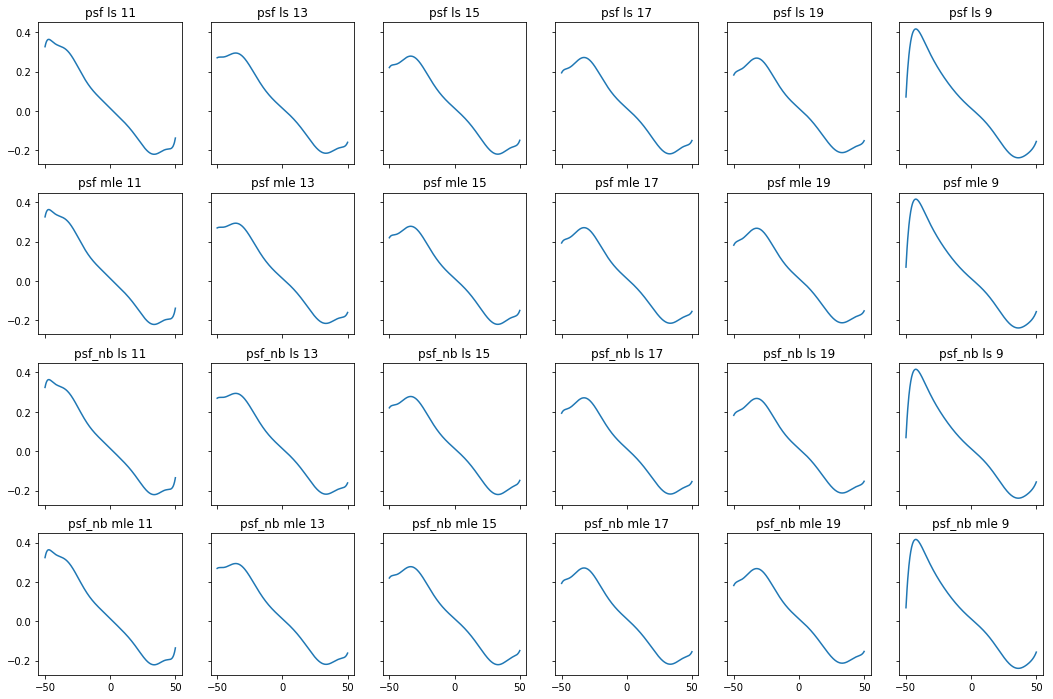

In [127]:
to_plot = {}
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            l = "{} {} {}".format(k, method, fitwin)
            df = fit_dict["poly_df"]
            v = fit_dict["corrected_fits"]
            x = v.index[np.abs(v.index) < 50]
            to_plot[l] = (x, np.poly1d(df.ellip)(x))
            print(df)

fig, axs = make_grid(len(to_plot), sharey=True, sharex=True)
for (k, v), ax in zip(sorted(to_plot.items()), axs.ravel()):
    ax.plot(*v)
    ax.set_title(k)

In [128]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            l = "{}/{}/win{}".format(k, method, fitwin)
            df = fit_dict["poly_df"]
            df.to_hdf("z_calib3_unweighted.h5", l)

A Jupyter Widget

In [145]:
j = psfs["psf"].fits_dict["mle"][19]["poly_df"] - psfs["psf_nb"].fits_dict["mle"][19]["poly_df"]

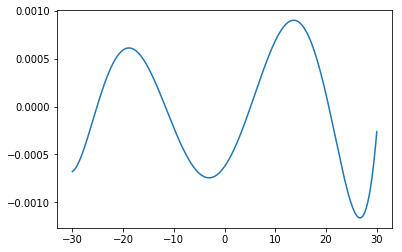

In [146]:
poly1d = np.poly1d(j.sigma_x.dropna())
x = np.linspace(-30, 30, 1024)
y = poly1d(x)
plt.plot(x, y)

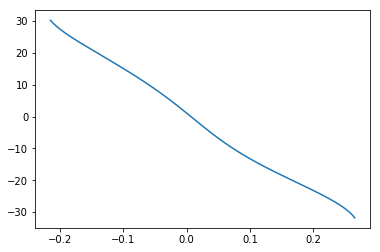

In [70]:
poly1d = np.poly1d(df.ellip)
xmin, xmax = find_real_roots_near_zero(polyd)
x = np.linspace(xmin*0.9, xmax*0.9, 1024)
y = poly1d(x)
plt.plot(y, x)

In [71]:
f = interp1d(y, x, bounds_error=False, assume_sorted=False)
f(0)

array(1.118809029038575)

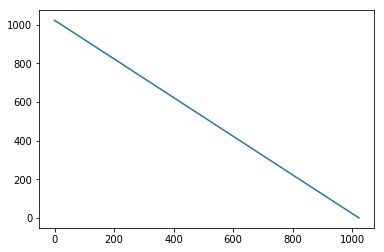

In [72]:
plt.plot(y.argsort())

In [73]:
(x[1] - x[0]) * 20

1.21476169182273

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


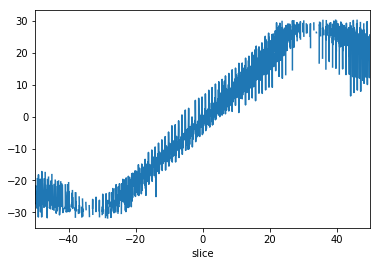

In [74]:
fit = fit_dict["corrected_fits"][np.abs(fit_dict["corrected_fits"].index) < 50]
fit["ellip"] = (fit.sigma_x - fit.sigma_y) / (fit.sigma_x + fit.sigma_y)
fit["z0"] = f(fit.ellip)
fit.z0.plot()

In [76]:
fit.head()

,amp,amp_e,noise,offset,offset_e,sigma_x,sigma_x_e,sigma_y,sigma_y_e,x0,x0_e,y0,y0_e,ellip,z0
slice,,,,,,,,,,,,,,,
-49.995002,455.895865,18.270807,46.482389,62.441429,21.055886,5.707975,0.307334,3.854293,0.223574,0.455287,0.122643,-0.030117,0.072250,0.193854,-22.630911
-49.924754,455.838684,48.516272,48.807322,-14.390026,53.509995,7.286525,0.734274,5.002619,0.531922,0.115458,0.159535,0.114069,0.088047,0.185847,-21.860414
-49.917871,571.090479,31.076394,70.526748,27.095781,35.098408,7.259891,0.534019,3.807625,0.276442,0.486954,0.206986,-0.083263,0.080647,0.311928,NaN
-49.869938,1244.913968,140.428121,104.386155,-308.799053,151.749094,7.861230,0.769421,5.407927,0.551962,0.369106,0.138292,-0.035106,0.073284,0.184888,-21.768590
-49.794487,554.328869,23.828101,59.736181,33.624520,27.358736,5.900679,0.338828,3.857547,0.236816,0.127675,0.135469,0.407213,0.075705,0.209375,-24.163572


In [77]:
poly_sigma_x = np.poly1d(df.sigma_x)
poly_sigma_y = np.poly1d(df.sigma_y)

In [78]:
sigma_x = poly_sigma_x(10.1)
sigma_y = poly_sigma_y(10.0)

In [79]:
sigma_x

1.1920045038613372

In [80]:
find_real_roots_near_zero(poly_sigma_x - sigma_x)

array([-61.26954071,   9.77798023])

In [81]:
find_real_roots_near_zero(poly_sigma_y - sigma_y)

array([-26.82323044,  10.        ])

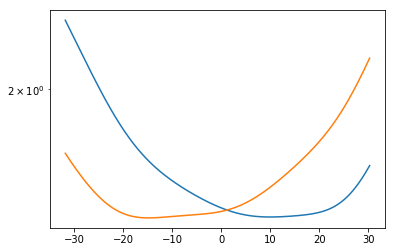

In [82]:
plt.semilogy(x, poly_sigma_x(x))
plt.semilogy(x, poly_sigma_y(x))

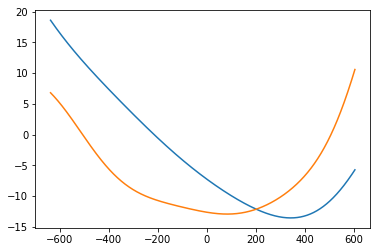

In [83]:
for k in ("x0", "y0"):
    p = np.poly1d(df[k])
    plt.plot(x*20, p(x)*130)